## Cat vs Dog Image Classifier using CNN in TensorFlow/Keras

📌 Project Overview

This project demonstrates a binary image classification task using a Convolutional Neural Network (CNN) to distinguish between images of cats and dogs. The model is trained using `TensorFlow` and `Keras` on the popular Cats vs Dogs dataset from TensorFlow Datasets (tfds).

### Dataset

- Source: cats_vs_dogs from TensorFlow Datasets

- Size: 25,000 labeled images (cats and dogs)

- Split: 80% training and 20% validation

All images are resized to 128x128 and normalized to improve training efficiency.

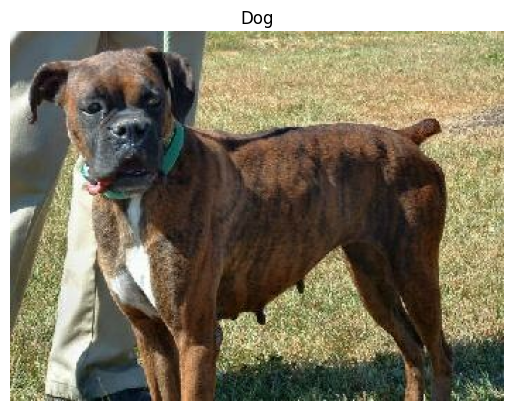

In [30]:
import tensorflow as tf
import tensorflow_datasets as tfds

(train_ds, val_ds), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

import matplotlib.pyplot as plt

for image, label in train_ds.take(1):
    plt.imshow(image)
    plt.title("Cat" if label == 0 else "Dog")
    plt.axis("off")
    plt.show()

### Preprocessing and Augmentation

To help the model learn better, training images are adjusted in different ways:

  - Some are flipped sideways.
  - Some have their brightness randomly changed.
  - Some have their contrast randomly adjusted.

Validation images are only resized and adjusted to have consistent colors—no extra changes.



In [31]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


### Model Architecture

To solve the cat vs. dog classification task, a custom Convolutional Neural Network (CNN) was built using `TensorFlow` and `Keras`. The model has three main blocks of convolutional layers, each followed by max pooling to gradually shrink the image size while capturing important features.

After the convolutional layers, the extracted features are flattened and passed through a dense layer with 128 neurons and ReLU activation. To prevent overfitting, a dropout layer removes 50% of the connections randomly. Finally, the model outputs a single neuron with a sigmoid activation function, which predicts how likely the image is a cat or a dog.

The model is trained using the Adam optimizer and binary cross-entropy loss, with accuracy as the main performance measure. This simple design works well for the task and can be improved in future versions.

In [21]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

To prevent overfitting and ensure the model generalizes well to unseen data, the `EarlyStopping` technique was applied. It monitors the validation loss during training and stops the process if the loss doesn't improve for 3 consecutive epochs. Additionally, the best-performing model weights (based on validation loss) are automatically restored.

This approach helps maintain a balance between underfitting and overfitting, resulting in a more robust model.

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stop]
)


Epoch 1/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.6084 - loss: 0.6617 - val_accuracy: 0.7504 - val_loss: 0.5075
Epoch 2/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 565s 968ms/step - accuracy: 0.7475 - loss: 0.5173 - val_accuracy: 0.7657 - val_loss: 0.4849
Epoch 3/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 564s 967ms/step - accuracy: 0.7872 - loss: 0.4614 - val_accuracy: 0.8181 - val_loss: 0.3963
Epoch 4/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 563s 966ms/step - accuracy: 0.8260 - loss: 0.3996 - val_accuracy: 0.8386 - val_loss: 0.3650
Epoch 5/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 615s 952ms/step - accuracy: 0.8407 - loss: 0.3593 - val_accuracy: 0.8629 - val_loss: 0.3312
Epoch 6/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 548s 938ms/step - accuracy: 0.8599 - loss: 0.3239 - val_accuracy: 0.8555 - val_loss: 0.3320
Epoch 7/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 547s 936ms/step - accuracy: 0.8703 - loss: 0.2996 - val_accuracy: 0.8510 - val_loss: 0.3479
Epoch 8/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 543s 930ms/step - accuracy: 0.8836 - lo

### Training Progress Visualization

To better understand the model's learning behavior over time, we plotted the training and validation accuracy and loss for each epoch. This visualization helps identify common training issues such as overfitting, underfitting, or unstable optimization.

In the accuracy plot, we expect both training and validation accuracy to steadily increase and ideally converge, while the loss should decrease. A noticeable gap between training and validation curves could indicate overfitting, which we mitigate using data augmentation and early stopping.



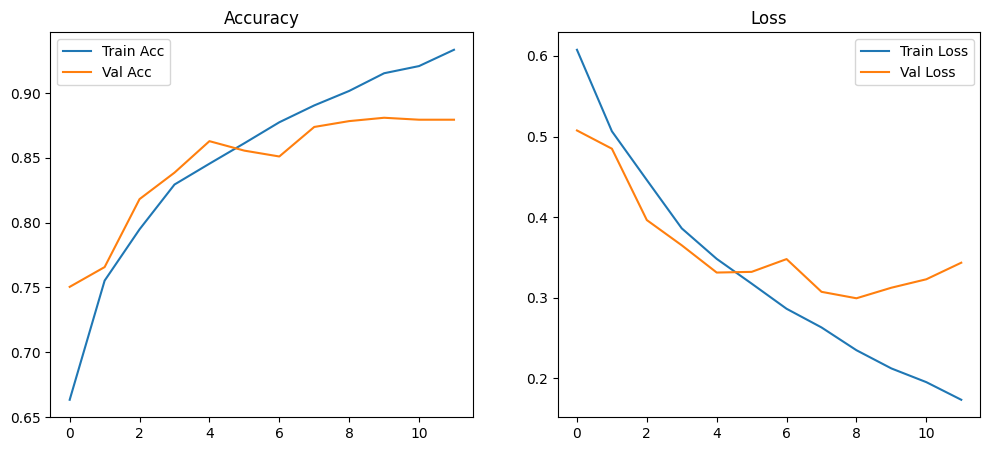

In [23]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)


### Misclassified Images - Error Analysis

To gain insights into model performance, we visualized a subset of misclassified validation images. These examples help identify edge cases where the model struggles to distinguish between cats and dogs.

Common misclassification patterns include:

- Unusual lighting conditions or angles

- Close-up images with ambiguous features

- Similar fur color or texture between classes

Below is a grid of sample misclassifications, where the true label and predicted label are shown for each image. This analysis can guide future improvements, such as enhanced data augmentation or transfer learning.

146/146 ━━━━━━━━━━━━━━━━━━━━ 47s 319ms/step


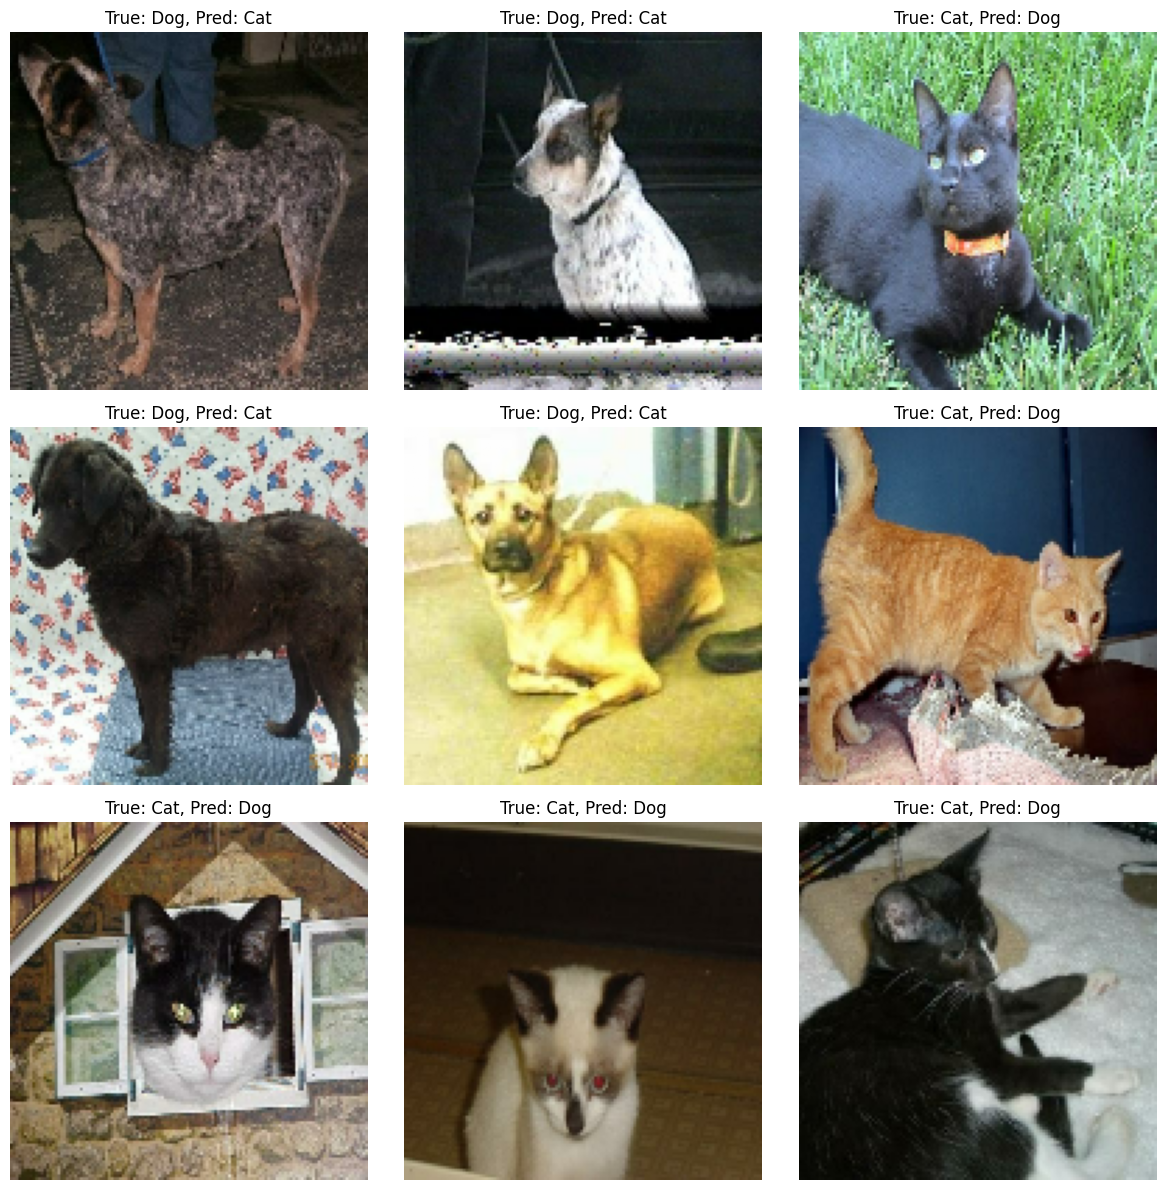

In [24]:
import numpy as np

predictions = model.predict(val_ds)
pred_labels = (predictions > 0.5).astype("int32").flatten()

true_labels = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

images = np.concatenate([x.numpy() for x, y in val_ds], axis=0)

wrong_idx = np.where(pred_labels != true_labels)[0]

plt.figure(figsize=(12, 12))
for i, idx in enumerate(wrong_idx[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[idx])
    plt.title(f"True: {'Dog' if true_labels[idx] else 'Cat'}, Pred: {'Dog' if pred_labels[idx] else 'Cat'}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [26]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy:.4f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 268ms/step - accuracy: 0.8804 - loss: 0.3025
Validation Accuracy: 0.8783


### Conclusion

The CNN model reached a validation accuracy of 87.83%, showing strong performance in identifying cats and dogs using a simple design without pretrained features. While the model works well, some misclassifications happened due to unclear poses, poor lighting, and similar visual traits between the two classes.

This result provides a solid starting point for image classification using CNNs. Possible improvements include:

- Using transfer learning with pretrained models like MobileNetV2 or EfficientNet

- Increasing image resolution for better detail capture

- Applying more varied image augmentation techniques

- Adding class activation maps (CAM) to better understand predictions

Overall, this project covers the full deep learning process—from data handling and model training to evaluation and error analysis.